# Econometria Séries Financeiras - Quiz I
## Debentures atreladas ao IPCA
Fernando Martinelli Ramacciotti - 301002
fernandoramacciotti@gmail.com

In [1]:
# importing libraries and source file
%matplotlib inline
import pandas as pd
import os
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

pathname = os.getcwd()
TimeSeriesXL = pd.ExcelFile(os.path.join(pathname, 'SeriesTemporaisHardcoded.xlsx'))

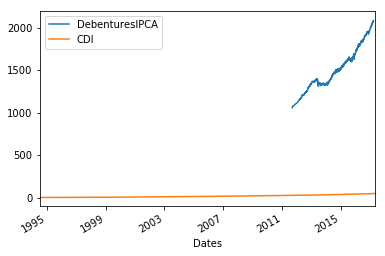

In [2]:
# generating daily and monthly excess of return series

# montlhy series
AllAssetClasses = pd.DataFrame()

for asset_class in TimeSeriesXL.sheet_names:
    #print(asset_class)
    df = TimeSeriesXL.parse(asset_class,index_col=0,skiprows=1)
    df.columns = [asset_class]
    df.index.name = 'Dates'
    AllAssetClasses = pd.concat([AllAssetClasses,df],join='outer',axis=1)

AllAssetClasses.plot()

AllAssetClasses = AllAssetClasses.resample('BM').last()

Returns = AllAssetClasses.pct_change(1)
EReturns = pd.DataFrame()
for asset_class in Returns.columns:
    EReturns[asset_class] = Returns[asset_class] - Returns['CDI']

EReturns = EReturns.drop('CDI',axis=1)


# daily series
AllAssetClasses_daily = pd.DataFrame()

for asset_class_daily in TimeSeriesXL.sheet_names:
    #print(asset_class_daily)
    df = TimeSeriesXL.parse(asset_class_daily, index_col=0, skiprows=1)
    df.columns = [asset_class_daily]
    df.index.name = 'Dates'
    AllAssetClasses_daily = pd.concat([AllAssetClasses_daily,df],join='outer',axis=1)

Returns_daily = AllAssetClasses_daily.pct_change(1)
EReturns_daily = pd.DataFrame()
for asset_class_daily in Returns.columns:
    EReturns_daily[asset_class_daily] = Returns_daily[asset_class_daily] - Returns_daily['CDI']

EReturns_daily = EReturns_daily.drop('CDI',axis=1)
EReturns_daily = EReturns_daily.dropna()


In [3]:
EReturns.tail() # monthly

,DebenturesIPCA
Dates,
2016-12-30,0.004777
2017-01-31,0.004255
2017-02-28,0.010822
2017-03-31,0.006677
2017-04-28,-0.000785


In [4]:
EReturns_daily.tail() # "daily"

,DebenturesIPCA
Dates,
2017-03-27,0.003757
2017-03-30,-0.002192
2017-04-04,0.001535
2017-04-07,0.000054
2017-04-11,0.000777


## Fato 1 - FAC dos Preços decai linearmente e FACP truncada de ordem 1

Confirmado. A FAC decai suavemente, aparentemente com um ponto de inflexão próximo ao lag 25, e a FACP apresenta nos mostra que somente o primeiro lag é estatisticamente significante

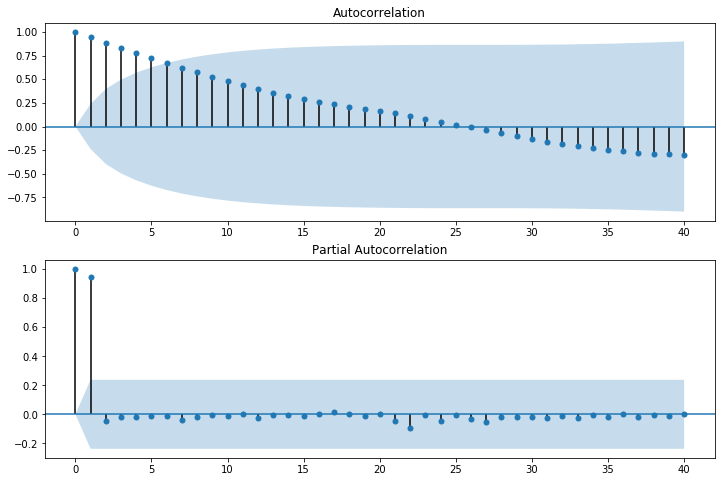

In [5]:
for asset_class in EReturns.columns:
    # Fato 1 - FAC decai linearmente, FACP só do 1o lag
    TS_in_levels = AllAssetClasses[asset_class].dropna()
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(TS_in_levels.values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(TS_in_levels, lags=40, ax=ax2)
    #plt.savefig(asset_class + '_FAC_levels.pdf')
    plt.show()

## Fato 2 - Série de Preços, em nível, não rejeita a hipótese nula de raiz unitária
Confirmado. A partir resultado do teste de Dickey-Fuller, não podemos rejeitar a hipótese nula de raiz unitária

In [6]:
 # Fato 2 - serie dos preços nao rejeita hip raiz unitaria
from statsmodels.tsa.stattools import adfuller

unit_root_test = adfuller(TS_in_levels)
test_out = pd.Series(unit_root_test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print('Results of Dickey-Fuller Test:')    
for key, value in unit_root_test[4].items():
    test_out['Critical Value (%s)' %key] = value
print(test_out)

Results of Dickey-Fuller Test:
Test Statistic                  1.955019
p-value                         0.998612
#Lags Used                      0.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


## Fato 3 - FAC e FACP dos retornos é igual a zero
Confirmado. Nenhum dos lags nas FAC e FACP são estatiscamente significantes.

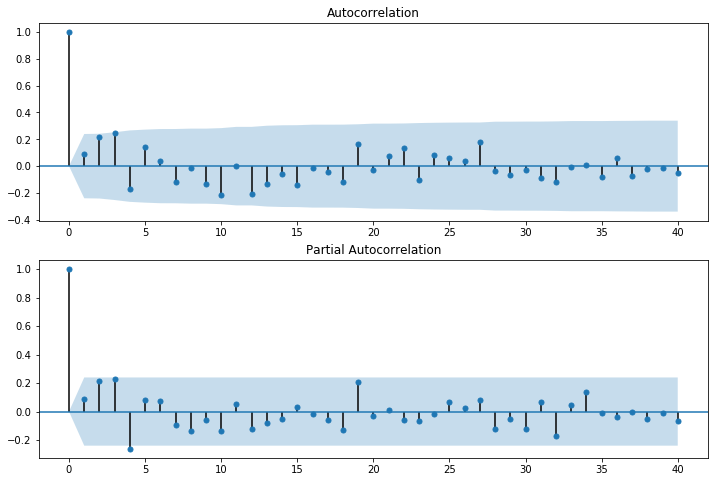

In [7]:
# Fato 3 - FAC e FACP dos retornos = 0
for asset_class in EReturns.columns:

    TS_in_returns = EReturns[asset_class].dropna()
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(TS_in_returns.values.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(TS_in_returns, lags=40, ax=ax2)
    #plt.savefig(asset_class + '_FAC_returns.pdf')
    plt.show()

## Fato 4 - Média dos retornos é positiva
Não confirmado. A média dos retornos estimada foi de 0.0014, mas com estatística t de 0.13, ou seja, estatisticamente igual a zero.

Mean = 0.001438
Std dev = 0.010956
T-statistc = 0.131249


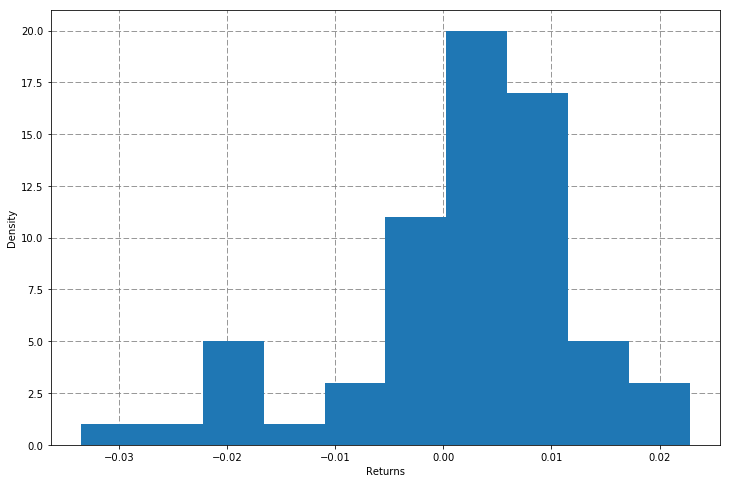

In [8]:
# Fato 4 - media dos retornos > 0

for asset_class in EReturns.columns:
    
    returns_summary = TS_in_returns.describe()
    print('Mean = %f' %returns_summary[1])
    print('Std dev = %f' %returns_summary[2])
    t_stat = returns_summary[1] / returns_summary[2]
    print('T-statistc = %f' %t_stat)
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    fig = plt.hist(TS_in_returns, zorder = 3)
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.grid(color = 'gray', linestyle = 'dashed', zorder = 0)
    #plt.savefig(asset_class + '_returns_histogram.pdf')
    plt.show()

## Fato 5 - A distribuição dos retornos tem "caudas largas"
Confirmado. Observando-se o qqplot, percebos que as "caudas" são mais largas que a de uma distribuição Normal.

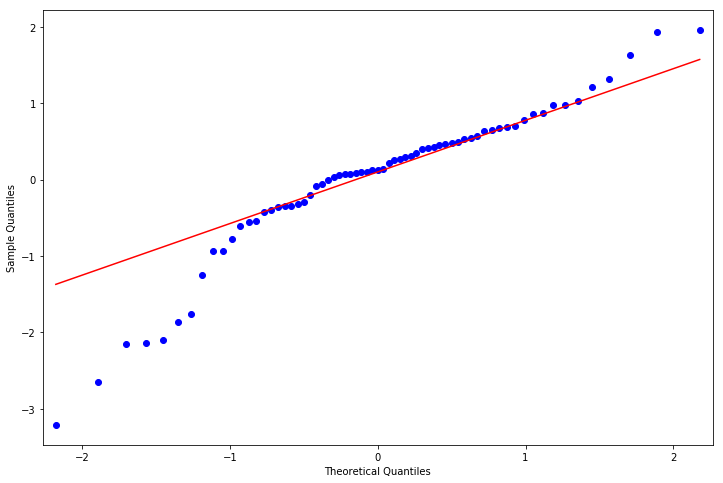

In [9]:
# Fato 5 - caudas largas

for asset_class in EReturns.columns:
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    fig = qqplot(TS_in_returns, line='q', ax=ax, fit=True)
    #plt.savefig(asset_class + '_returns_qqplot.pdf')
    plt.show()

## Fato 6 - A série de retornos apresenta clusters de volatilidade
Confirmado. Temos que pelo menos um dos coeficientes, $\alpha$ ou $\beta$, são estatistamente significantes, indicando que há clusters de volatilidade. No caso, temos que $\beta$ é significante.

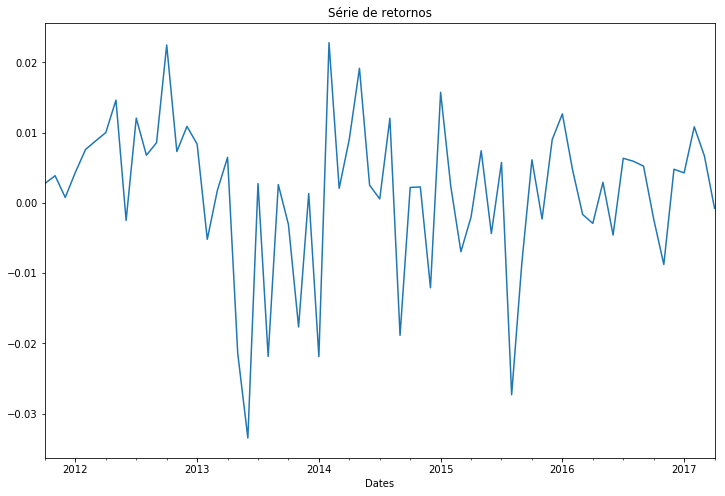

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -209.091961969
            Iterations: 3
            Function evaluations: 41
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         DebenturesIPCA   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                209.092
Distribution:                  Normal   AIC:                          -410.184
Method:            Maximum Likelihood   BIC:                          -401.365
                                        No. Observations:                   67
Date:                Thu, Jun 01 2017   Df Residuals:                       63
Time:                        00:08:22   Df Model:                            4
                                  Mean Model                                  
     

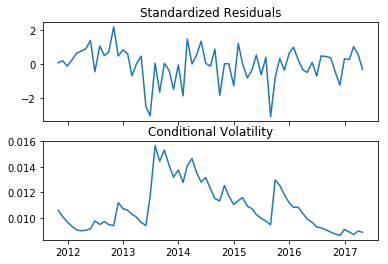

In [10]:
# Fato 6 - cluster de volatilidade
# regressao retornos^2

for asset_class in EReturns.columns:
    TS_in_returns_2 = TS_in_returns.apply(lambda x: x**2)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    fid = TS_in_returns.plot()
    plt.title('Série de retornos')
    #plt.savefig(asset_class + 'returns_plot.pdf')
    plt.show()
    
    # modelo GARCH(1, 1) para testar o cluster de volatilidade
    from arch import arch_model
    
    garch = arch_model(TS_in_returns, p = 1, q = 1)
    res = garch.fit(update_freq = 5)
    print(res.summary())
    res.plot()
    

## Fato 7 - Maior volatilidade na abertura pós fins-de-semana
Confirmado. Foi feito um caso mais genérico criando-se uma dummy para indicar quando a diferença entre os pontos fosse maior que 1 dia. Rodando-se a regressão dos retornos ao quadrado nos retornos ao quadrado de um período anterior, com o termo de interação dessa dummy com os retornos de lag 1, temos que o coeficiente no termo de interação é significativo, indicando a presença do fenômeno.

In [11]:
#Fato 7 - maior volatilidade na abertura do fds

for asset_class in EReturns.columns:
    TS_in_returns_daily = EReturns_daily[asset_class].dropna()
    TS_in_returns_daily_2 = TS_in_returns_daily.apply(lambda x: x**2)
    lag_return = TS_in_returns_daily_2.shift()
    days_diff = TS_in_returns_daily_2.index.to_series().diff().dt.days
    daily_returns_2_df = pd.DataFrame(TS_in_returns_daily_2)
    daily_returns_2_df['lagged_return'] = lag_return.dropna()
    daily_returns_2_df['days_diff'] = np.where(days_diff > 1, 1, 0)
    daily_returns_2_df['return'] = TS_in_returns_daily

import statsmodels.formula.api as smf    
reg_7 = smf.ols(formula = 'DebenturesIPCA ~ lagged_return + lagged_return * days_diff', data = daily_returns_2_df).fit()
reg_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         DebenturesIPCA   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     64.12
Date:                Thu, 01 Jun 2017   Prob (F-statistic):           1.11e-38
Time:                        00:08:23   Log-Likelihood:                 11582.
No. Observations:                1314   AIC:                        -2.316e+04
Df Residuals:                    1310   BIC:                        -2.313e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                5.503e-06   1.19e-06      4.616      0.000      3.16e-06  7.84e-06
lagged_return               0.3752      0.027     13.826      0.000         0.322     0.428
days_diff                3.076e-06   2.35e-06      1.309      0.191     -1.54e-06  7.69e-06
lagged_return:days_diff    -0.2842      0.088     -3.240      0.001        -0.456    -0.112
==============================================================================
Omnibus:                     2239.151   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2301171.385
Skew:                          11.031   Prob(JB):                         0.00
Kurtosis:                     206.823   Cond. No.                     9.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fato 9 - Leverage effect
Não confirmado. Rodou-se uma regressão semelhante a do Fato 7, mas a dummy indica retornos negativos. O termo de interação não é estatisticamente significante.

In [12]:
# Fato 9 - leverage effect
    
for asset_class in EReturns.columns:
    monthly_returns_df = pd.DataFrame()
    monthly_returns_df['returns'] = TS_in_returns
    monthly_returns_df['return_square'] = TS_in_returns_2
    monthly_returns_df['lagged_return'] = TS_in_returns.shift()
    monthly_returns_df['lagged_return_square'] = TS_in_returns_2.shift()
    monthly_returns_df['neg_return'] = np.where(monthly_returns_df['lagged_return']<0,1,0)

    
reg_9 = smf.ols(formula = 'return_square ~ lagged_return_square + lagged_return_square*neg_return', data = monthly_returns_df).fit()
reg_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          return_square   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.6240
Date:                Thu, 01 Jun 2017   Prob (F-statistic):              0.602
Time:                        00:08:23   Log-Likelihood:                 468.87
No. Observations:                  66   AIC:                            -929.7
Df Residuals:                      62   BIC:                            -921.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.0001   3.71e-05      3.602      0.001      5.95e-05     0.000
lagged_return_square               -0.2118      0.259     -0.818      0.416        -0.729     0.306
neg_return                      -3.317e-05   6.63e-05     -0.500      0.619        -0.000  9.94e-05
lagged_return_square:neg_return     0.3712      0.300      1.236      0.221        -0.229     0.971
==============================================================================
Omnibus:                       53.354   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.169
Skew:                           2.474   Prob(JB):                     1.40e-46
Kurtosis:                      10.232   Cond. No.                     1.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regressões de Longo Prazo

O spread de crédito será a variável preditiva de retorno de Debêntures atreladas ao IPCA. Como a série de Debentures é relativamente pequena e recente (desde 2011), usaremos os retornos mensais para obter-se uma amostra maior.
A regressão será do tipo $$ExcessoRetornoIDAIPCA = a + b.spreadCredito + erro$$

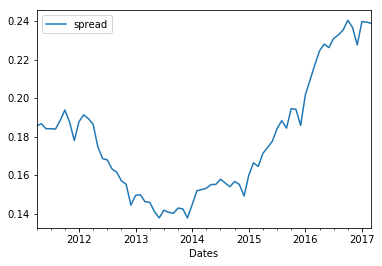

In [13]:
# importing credit spread series - fonte: IPEADATA

spread_series = pd.ExcelFile(os.path.join(pathname, 'spread_credito.xls'))

spread = pd.DataFrame()

for asset_class in spread_series.sheet_names:
    #print(asset_class)
    df = spread_series.parse(asset_class, index_col = 0, skiprows = 1)
    df.columns = [asset_class]
    df.index.name = 'Dates'
    spread = pd.concat([spread, df], join = 'outer', axis = 1)
    
spread.plot()

# forward fill da series
TS_in_returns = pd.concat([TS_in_returns, spread], axis = 1).fillna(method = 'ffill')


In [14]:
# criando serie de retornos acumulados


Returns = AllAssetClasses.pct_change(1)
EReturns = pd.DataFrame()
for asset_class in Returns.columns:
    EReturns[asset_class] = Returns[asset_class] - Returns['CDI']

for i in range(12, 61, 12):
    Returns = AllAssetClasses.pct_change(i)
    EReturns = pd.DataFrame()
    for asset_class in Returns.columns:
        EReturns[asset_class] = Returns[asset_class] - Returns['CDI']
    
    TS_in_returns['cum' + str(i)] = EReturns['DebenturesIPCA']


# rodando regressao
reg_lp_12 = smf.ols(formula = 'cum12 ~ spread', data = TS_in_returns).fit()
reg_lp_24 = smf.ols(formula = 'cum24 ~ spread', data = TS_in_returns).fit()
reg_lp_36 = smf.ols(formula = 'cum36 ~ spread', data = TS_in_returns).fit()
reg_lp_48 = smf.ols(formula = 'cum48 ~ spread', data = TS_in_returns).fit()
reg_lp_60 = smf.ols(formula = 'cum60 ~ spread', data = TS_in_returns).fit()




In [15]:
from statsmodels.iolib.summary2 import summary_col
print(summary_col([reg_lp_12, reg_lp_24, reg_lp_36, reg_lp_48, reg_lp_60], 
                  stars = True, 
                  float_format = '%0.2f', 
                  info_dict = {'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared)}, 
                 model_names = ['1y', '2y', '3y', '4y', '5y']))

C:\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'



            1y     2y     3y      4y      5y  
----------------------------------------------
Intercept 0.01   -0.03  0.07   0.49***  0.12  
          (0.04) (0.03) (0.07) (0.08)   (0.29)
spread    0.01   0.15   -0.31  -2.19*** -0.01 
          (0.21) (0.15) (0.36) (0.37)   (1.22)
N         56     44     32     20       8     
R2        0.00   0.03   0.02   0.66     0.00  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Observa-se um R2 de 66% para os retornos de 4 anos além dos coeficientes significantes à menos de 1%. O fato não é observado para os demais casos. Esperava-se encontrar tambem um R2 alto para os retornos de 5 anos, mas não foi o caso - devido a poucas observações na amostra.
Devemos tomar cuidado, no entanto, com os resultados devido ao pequeno tamanho da amostra por tratar-se de uma série recente.